In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.stats as st
import seaborn.objects as so
import seaborn as sns

In [36]:
palette = ['#7a5195', '#ef5675', '#ffa600'] #https://matplotlib.org/stable/gallery/color/named_colors.html
marker_size = 8  # Ustalony rozmiar markerów
xlabel = "Distance beetwen AP and STAs [m]"

In [37]:
data = pd.read_csv('MLOn1.csv').drop_duplicates()
data

,rngRun,flow,nStations,distance,linksNumber,loss,jitter,latency,throughput,rxBytes,...,txPackets,timeFirstRxPacket,timeFirstTxPacket,timeLastRxPacket,timeLastTxPacket,jitterSum,delaySum,rateAdaptationManager,scenario,MLOn
0,407456,1,1,1,2,71.3242,0.000547,2.13666,30.6917,482601992,...,1101413,1.03377,1.03377,121.000,121.000,172.8090,674841.0,ns3::ThompsonSamplingWifiManager,B,0
1,407456,2,1,1,2,71.3454,0.000547,2.13914,30.6654,482244440,...,1101413,1.01367,1.01367,120.994,120.994,172.5420,675122.0,ns3::ThompsonSamplingWifiManager,B,0
2,407456,3,1,1,2,71.2597,0.000544,2.13545,30.7564,483686872,...,1101413,1.01721,1.01721,121.000,121.000,172.2400,675973.0,ns3::ThompsonSamplingWifiManager,B,0
3,407456,4,1,1,2,71.0656,0.000540,2.12394,30.9651,486953736,...,1101413,1.01905,1.01905,120.998,120.998,171.9960,676873.0,ns3::ThompsonSamplingWifiManager,B,0
4,407456,1,1,1,2,71.3219,0.000546,2.13618,30.6965,482640192,...,1101413,1.02326,1.02326,120.980,120.980,172.5590,674742.0,ns3::ThompsonSamplingWifiManager,C,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,407461,4,1,1,2,46.7238,0.000198,1.42087,57.0200,896616648,...,1101413,1.02642,1.02642,120.995,120.995,116.3550,833754.0,ns3::ThompsonSamplingWifiManager,C,4
356,407461,1,1,1,3,24.4864,0.000081,1.10932,80.8031,1270863576,...,1101413,1.00561,1.00561,121.000,121.000,67.5583,922637.0,ns3::ThompsonSamplingWifiManager,D,4
357,407461,2,1,1,3,24.6501,0.000081,1.12173,80.6346,1268108592,...,1101413,1.01544,1.01544,121.000,121.000,67.5746,930939.0,ns3::ThompsonSamplingWifiManager,D,4
358,407461,3,1,1,3,24.6185,0.000081,1.13297,80.6649,1268640336,...,1101413,1.00628,1.00628,120.996,120.996,67.3343,940662.0,ns3::ThompsonSamplingWifiManager,D,4


In [38]:
# Utwórz kolumny logiczne
data = data.copy()
data['flow_leq_MLOn'] = data['flow'] <= data['MLOn']
data['flow_gt_MLOn'] = data['flow'] > data['MLOn']

In [39]:
df0 = (
    data[data['flow_leq_MLOn']]
    .groupby(['scenario', 'distance', 'linksNumber', 'rngRun', 'MLOn'], as_index=False)
    .mean(numeric_only=True)
    .assign(flow='≤MLOn')
)

df1 = (
    data[data['flow_gt_MLOn']]
    .groupby(['scenario', 'distance', 'linksNumber', 'rngRun', 'MLOn'], as_index=False)
    .mean(numeric_only=True)
    .assign(flow='>MLOn')
)

#  Suma flow 0 + 1
df_sum = (
    data
        .groupby(['scenario', 'distance', 'linksNumber', 'rngRun', 'MLOn'], as_index=False)
        .mean(numeric_only=True)
        .assign(flow='1+2')                       # sztuczna etykieta – tylko żeby było wiadomo
)

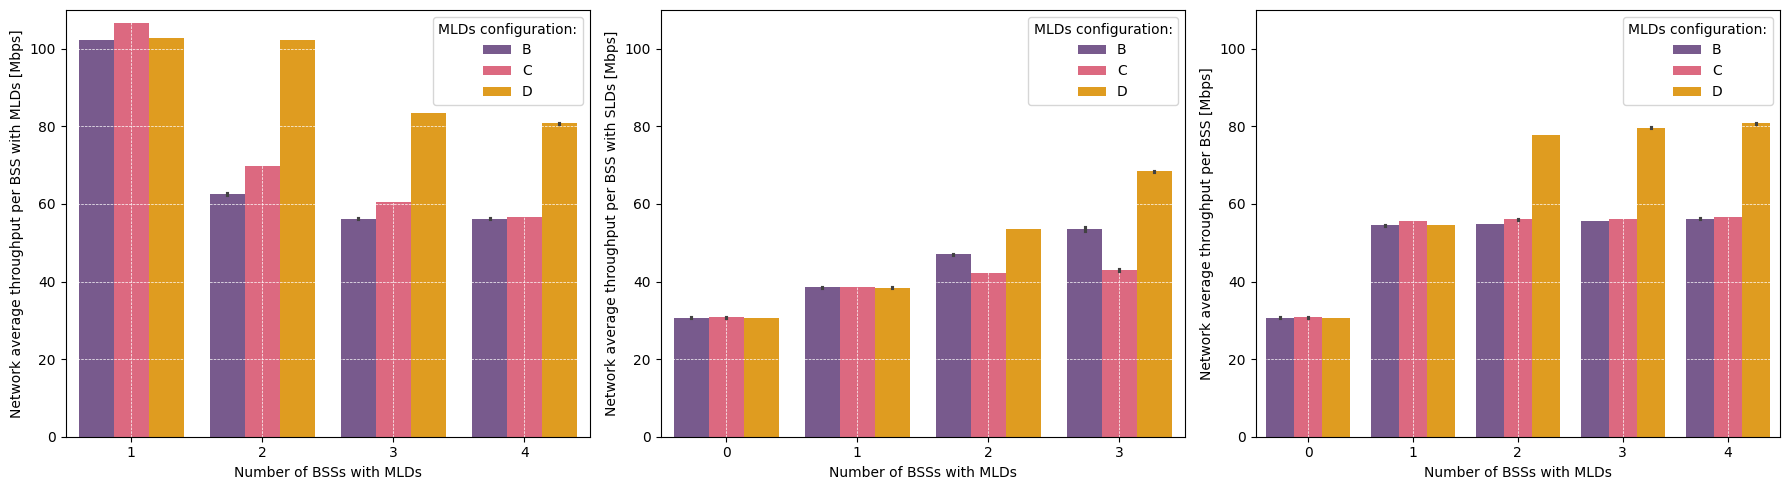

In [40]:
# ----------- Parametry wykresu -----------

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)  # Trzy wykresy w jednym rzędzie
xlabel = "Number of BSSs with MLDs"

# Listy danych i tytułów do iteracji
plot_data = [
    (df0, 'Network average throughput per BSS with MLDs [Mbps]'),
    (df1, 'Network average throughput per BSS with SLDs [Mbps]'),
    (df_sum, 'Network average throughput per BSS [Mbps]')
]

# ----------- Rysowanie wykresów -----------

for i, (df, title) in enumerate(plot_data):
    sns.barplot(data=df, x='MLOn', y='throughput', hue='scenario',
                 errorbar=('ci'), palette=palette,
                 ax=axes[i])

    axes[i].tick_params(axis='y', which='both', labelleft=True)
    for line in axes[i].get_lines():
        line.set_markersize(marker_size)

    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(
        handles=handles[0:7],  # Przytnij, jeśli trzeba
        labels=['B', 'C', 'D'],  # Twoje etykiety
        ncol=1,
        fontsize='medium',   # Rozmiar czcionki
       title='MLDs configuration:',         # <- Tytuł legendy
       title_fontsize='medium'    # <- Rozmiar czcionki tytułu
    )

    axes[i].set(xlabel=xlabel, ylabel=title)
    if i != 2:
        axes[i].set_ylim(0, 110)
    else:
        axes[i].set_ylim(0, 110) #, 225
    axes[i].grid(color='white', linestyle='--', linewidth=0.5)

# ----------- Zapis i wyświetlenie -----------

plt.tight_layout()
plt.savefig('dist_thr_flows3.svg', bbox_inches='tight')
plt.show()

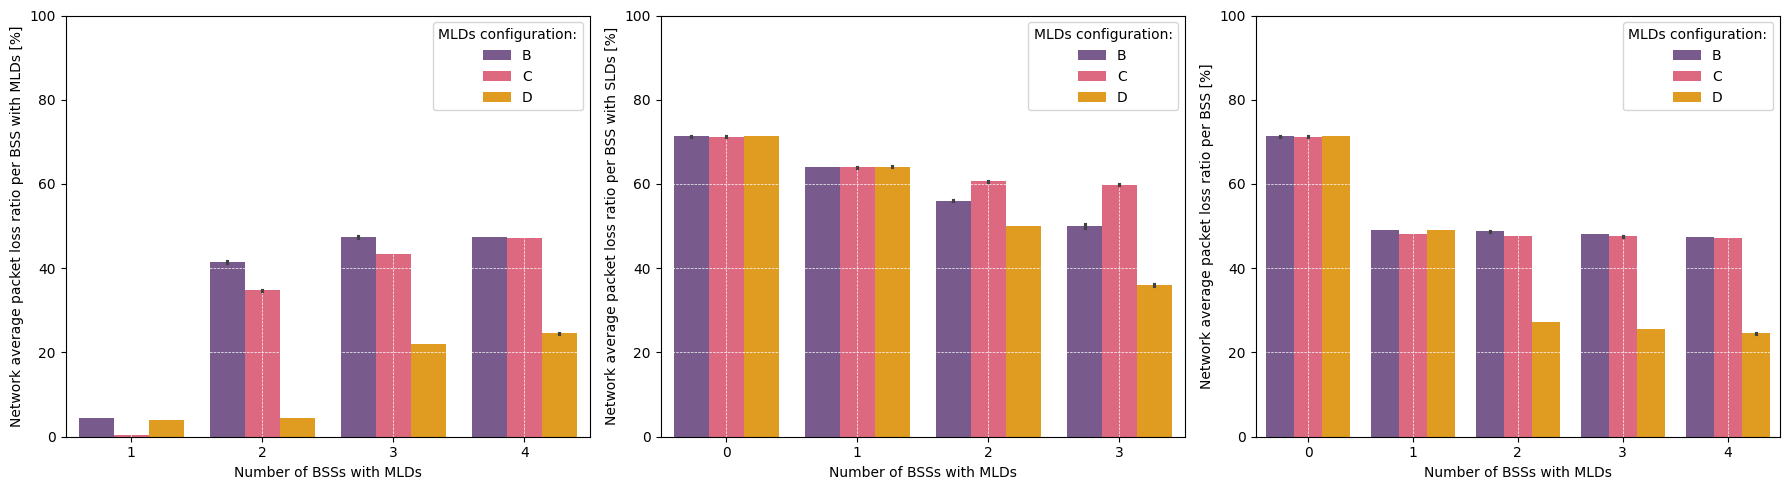

In [41]:
# ----------- Parametry wykresu -----------

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)  # Trzy wykresy w jednym rzędzie
xlabel = "Number of BSSs with MLDs"

# Listy danych i tytułów do iteracji
plot_data = [
    (df0, 'Network average packet loss ratio per BSS with MLDs [%]'),
    (df1, 'Network average packet loss ratio per BSS with SLDs [%]'),
    (df_sum, 'Network average packet loss ratio per BSS [%]')
]

# ----------- Rysowanie wykresów -----------

for i, (df, title) in enumerate(plot_data):
    sns.barplot(data=df, x='MLOn', y='loss', hue='scenario',
                 errorbar=('ci'), palette=palette,
                 ax=axes[i])

    axes[i].tick_params(axis='y', which='both', labelleft=True)
    for line in axes[i].get_lines():
        line.set_markersize(marker_size)

    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(
        handles=handles[0:7],  # Przytnij, jeśli trzeba
        labels=['B', 'C', 'D'],  # Twoje etykiety
        ncol=1,
        fontsize='medium',   # Rozmiar czcionki
       title='MLDs configuration:',         # <- Tytuł legendy
       title_fontsize='medium'    # <- Rozmiar czcionki tytułu
    )

    axes[i].set(xlabel=xlabel, ylabel=title)
    if i != 2:
        axes[i].set_ylim(0, 100)
    else:
        axes[i].set_ylim(0, 100) #, 225
    axes[i].grid(color='white', linestyle='--', linewidth=0.5)

# ----------- Zapis i wyświetlenie -----------

plt.tight_layout()
plt.savefig('dist_loss_flows3.svg', bbox_inches='tight')
plt.show()

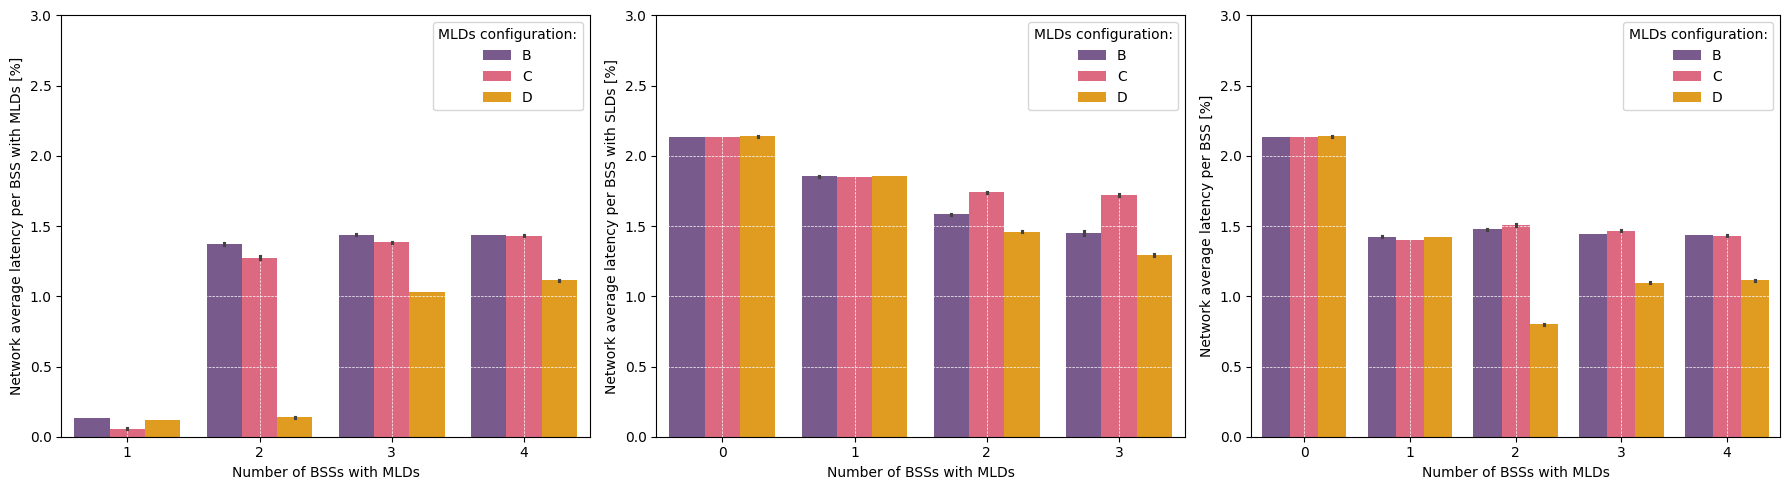

In [42]:
# ----------- Parametry wykresu -----------

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)  # Trzy wykresy w jednym rzędzie
xlabel = "Number of BSSs with MLDs"

# Listy danych i tytułów do iteracji
plot_data = [
    (df0, 'Network average latency per BSS with MLDs [%]'),
    (df1, 'Network average latency per BSS with SLDs [%]'),
    (df_sum, 'Network average latency per BSS [%]')
]

# ----------- Rysowanie wykresów -----------

for i, (df, title) in enumerate(plot_data):
    sns.barplot(data=df, x='MLOn', y='latency', hue='scenario',
                 errorbar=('ci'), palette=palette,
                 ax=axes[i])

    axes[i].tick_params(axis='y', which='both', labelleft=True)
    for line in axes[i].get_lines():
        line.set_markersize(marker_size)

    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(
        handles=handles[0:7],  # Przytnij, jeśli trzeba
        labels=['B', 'C', 'D'],  # Twoje etykiety
        ncol=1,
        fontsize='medium',   # Rozmiar czcionki
       title='MLDs configuration:',         # <- Tytuł legendy
       title_fontsize='medium'    # <- Rozmiar czcionki tytułu
    )

    axes[i].set(xlabel=xlabel, ylabel=title)
    if i != 2:
        axes[i].set_ylim(0, 3)
    else:
        axes[i].set_ylim(0, 3) #, 225
    axes[i].grid(color='white', linestyle='--', linewidth=0.5)

# ----------- Zapis i wyświetlenie -----------

plt.tight_layout()
plt.savefig('dist_latency_flows3.svg', bbox_inches='tight')
plt.show()

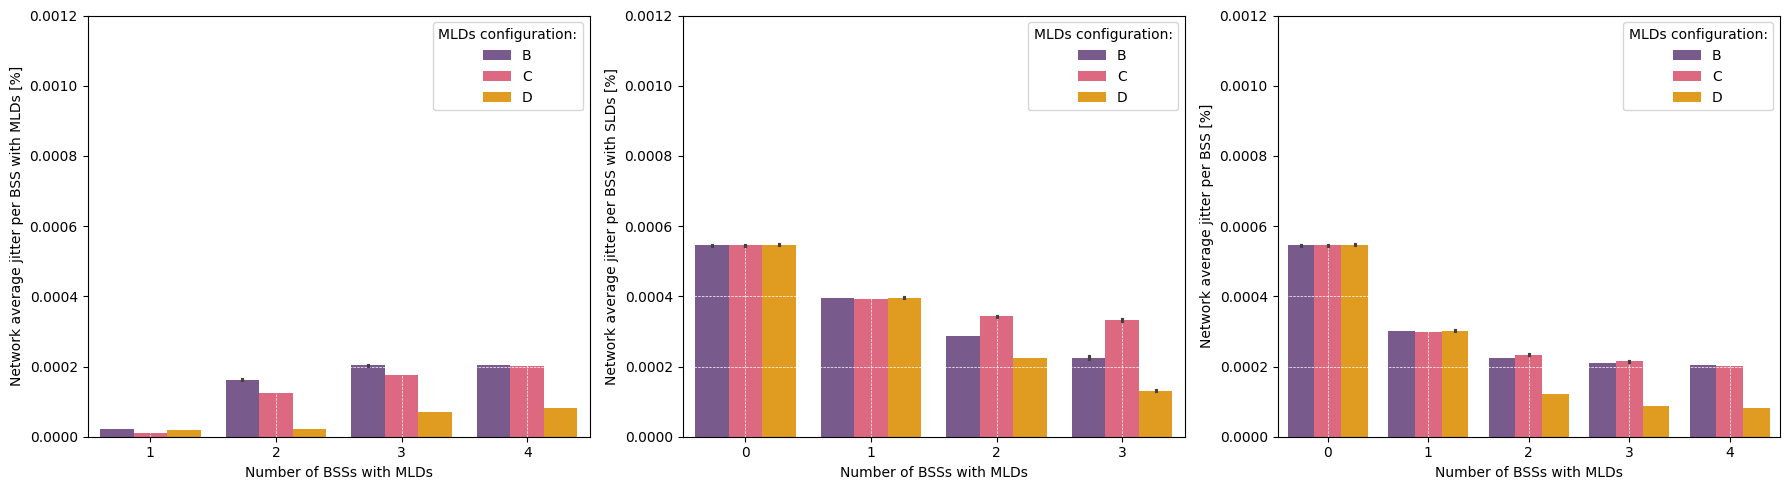

In [43]:
# ----------- Parametry wykresu -----------

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)  # Trzy wykresy w jednym rzędzie
xlabel = "Number of BSSs with MLDs"

# Listy danych i tytułów do iteracji
plot_data = [
    (df0, 'Network average jitter per BSS with MLDs [%]'),
    (df1, 'Network average jitter per BSS with SLDs [%]'),
    (df_sum, 'Network average jitter per BSS [%]')
]

# ----------- Rysowanie wykresów -----------

for i, (df, title) in enumerate(plot_data):
    sns.barplot(data=df, x='MLOn', y='jitter', hue='scenario',
                 errorbar=('ci'), palette=palette,
                 ax=axes[i])

    axes[i].tick_params(axis='y', which='both', labelleft=True)
    for line in axes[i].get_lines():
        line.set_markersize(marker_size)

    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(
        handles=handles[0:7],  # Przytnij, jeśli trzeba
        labels=['B', 'C', 'D'],  # Twoje etykiety
        ncol=1,
        fontsize='medium',   # Rozmiar czcionki
       title='MLDs configuration:',         # <- Tytuł legendy
       title_fontsize='medium'    # <- Rozmiar czcionki tytułu
    )

    axes[i].set(xlabel=xlabel, ylabel=title)
    if i != 2:
        axes[i].set_ylim(0, 0.0012)
    else:
        axes[i].set_ylim(0, 0.0012) #, 225
    axes[i].grid(color='white', linestyle='--', linewidth=0.5)

# ----------- Zapis i wyświetlenie -----------

plt.tight_layout()
plt.savefig('dist_jitter_flows3.svg', bbox_inches='tight')
plt.show()